### Installing NeuralForecast (If Required)

In [1]:
%%capture
!pip install neuralforecast

#### Useful functions

The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import matplotlib.pyplot as plt

def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'],
                        test_uid[f'{model}-lo-{l}'],
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

### Loading M4 Data

For testing purposes, we will use the Hourly dataset from the [M4 competition]. It's hosted online and easy to download and use with `neuralforecast` (https://www.researchgate.net/publication/325901666_The_M4_Competition_Results_findings_conclusion_and_way_forward).

In [9]:
import subprocess
import requests
import os

def download_file(url, output_filename):
    try:
        # Try using wget
        subprocess.run(['wget', url, '-O', output_filename], check=True)
        print(f"File downloaded using wget: {output_filename}")
    except (subprocess.CalledProcessError, FileNotFoundError):
        # Fallback to requests if wget fails
        print("wget not available, using requests.")
        response = requests.get(url)
        response.raise_for_status()  # Will raise an HTTPError for bad requests
        with open(output_filename, 'wb') as f:
            f.write(response.content)
        print(f"File downloaded using requests: {output_filename}")

# URLs and corresponding output file names
urls = [
    "https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv",
    "https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv"
]
output_filenames = [
    "M4-Hourly.csv",
    "M4-Hourly-test.csv"
]

# Download each file
for url, filename in zip(urls, output_filenames):
    download_file(url, filename)


wget not available, using requests.
File downloaded using requests: M4-Hourly.csv
wget not available, using requests.
File downloaded using requests: M4-Hourly-test.csv


In [10]:
import pandas as pd

In [11]:
Y_train_df = pd.read_csv('M4-Hourly.csv')
Y_test_df = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [12]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

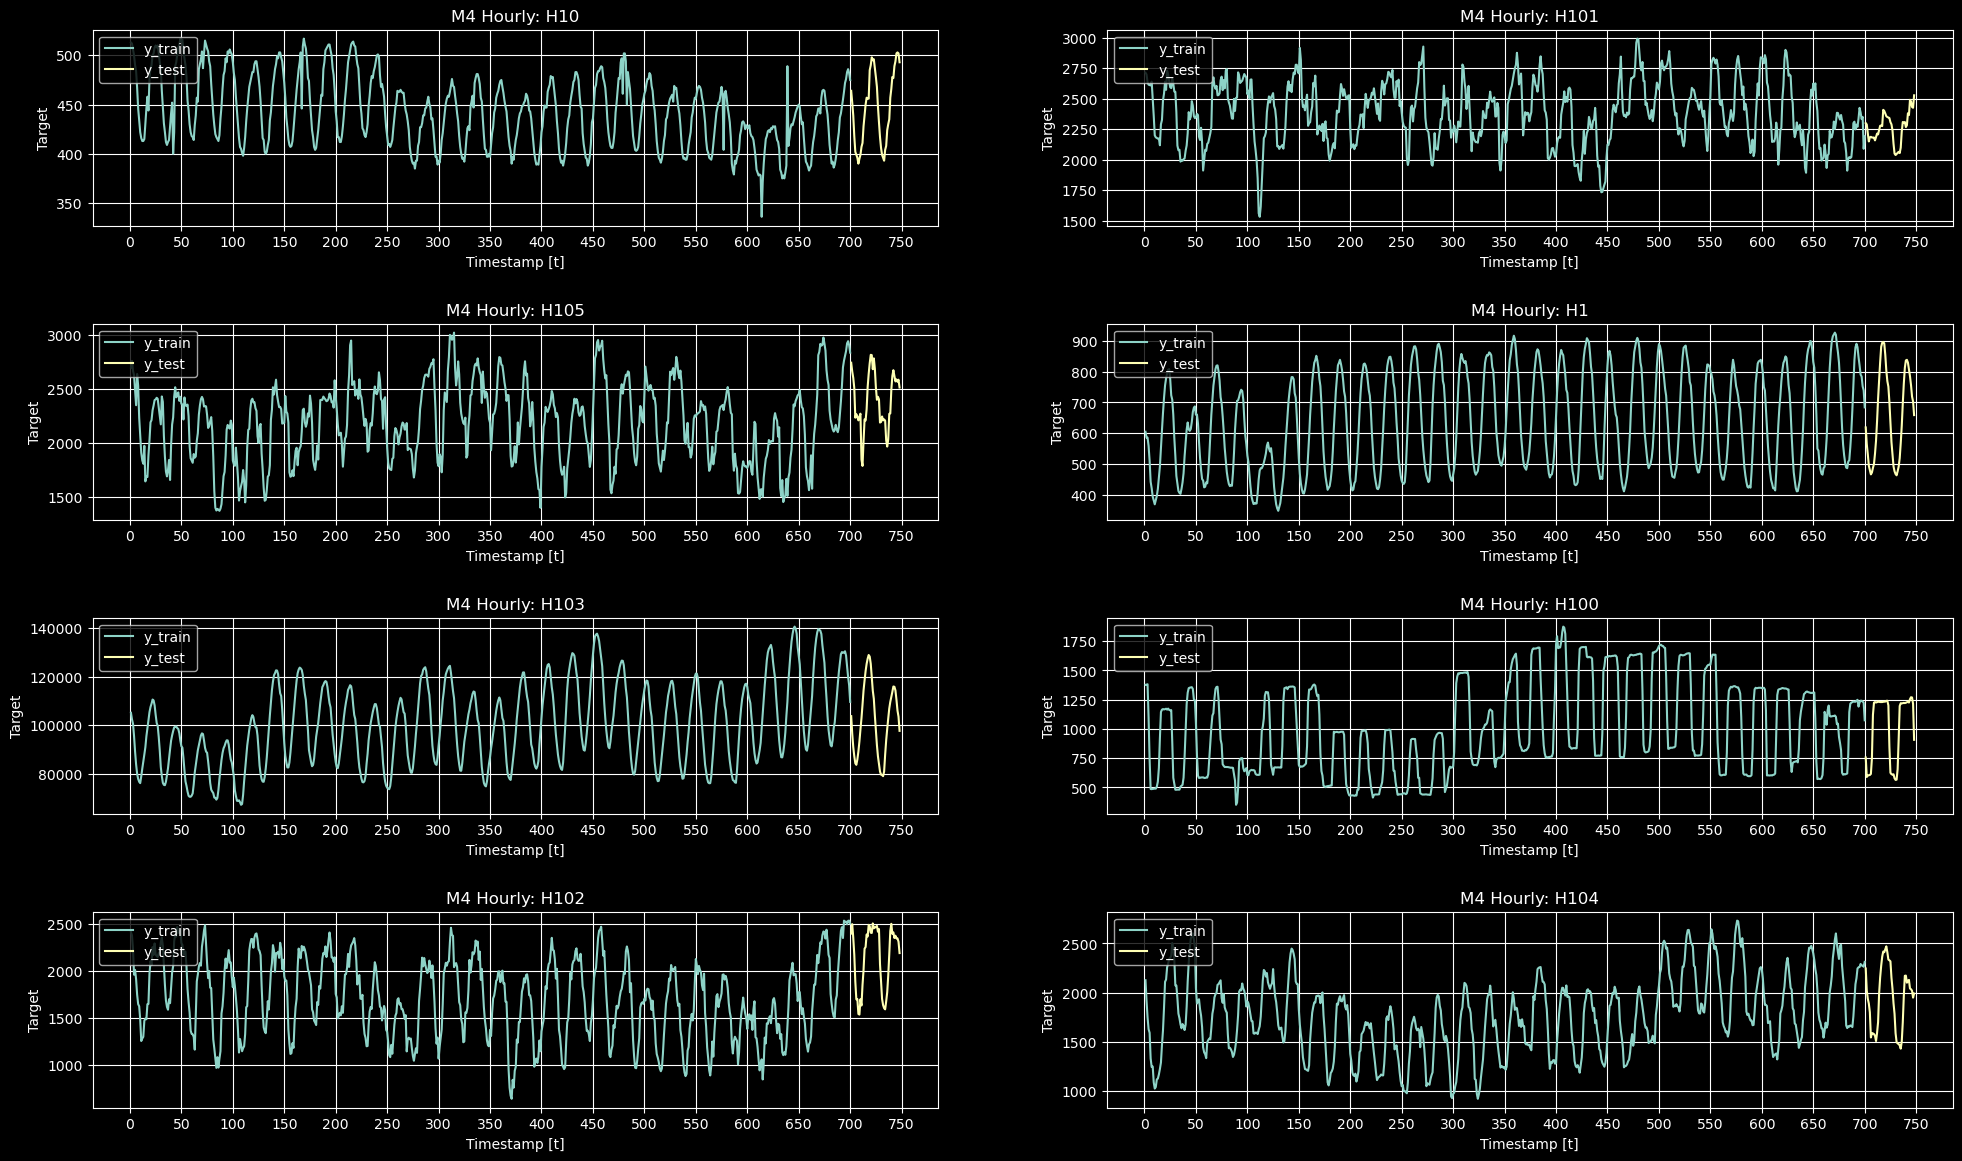

In [13]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Training

We have already seen how to use `neuralforecast` in Chapter 16. Here, lets see how we can use the same code and make it work for Quantile prediction. We are going to use a simple LSTM, but the same strategy and code can be used for all the models in `neuralforecast`.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `DistributionLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals.
- `input_size` controls the size of the context window
- `encoder_hidden_size` and `decoder_hidden_size` are parameters of the LSTM. We have kept it small so that the run's are faster. These parameters should be ideally tuned and we can use `AutoLSTM` or any of the `Auto<Model>` in `neuralforecast`.

In [14]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import LSTM
from neuralforecast.losses.pytorch import MQLoss

In [15]:
horizon = 48
levels = [80, 90]
lstm_config = dict(
    input_size=3 * horizon
)
models = [LSTM(h=horizon, loss=MQLoss(level=levels), **lstm_config)]
# Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
nf = NeuralForecast(models=models, freq=1)

Seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [16]:
%%capture
nf.fit(df=Y_train_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 484 K 
4 | context_adapter | Linear        | 96.5 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
583 K     Trainable params
5         Non-trainable params
583 K     Total params
2.335     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=1000` reached.


In [17]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point rediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90
0,H1,701,595.739563,509.562042,536.167969,642.396851,670.277893
1,H1,702,540.314697,433.306946,464.785522,604.624146,636.411072
2,H1,703,493.031097,367.928497,410.444458,573.558716,603.604675
3,H1,704,459.343323,333.415405,375.255951,544.380981,576.579407
4,H1,705,440.466370,320.767731,343.908844,528.508362,566.995178


In [18]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

#### LSTM

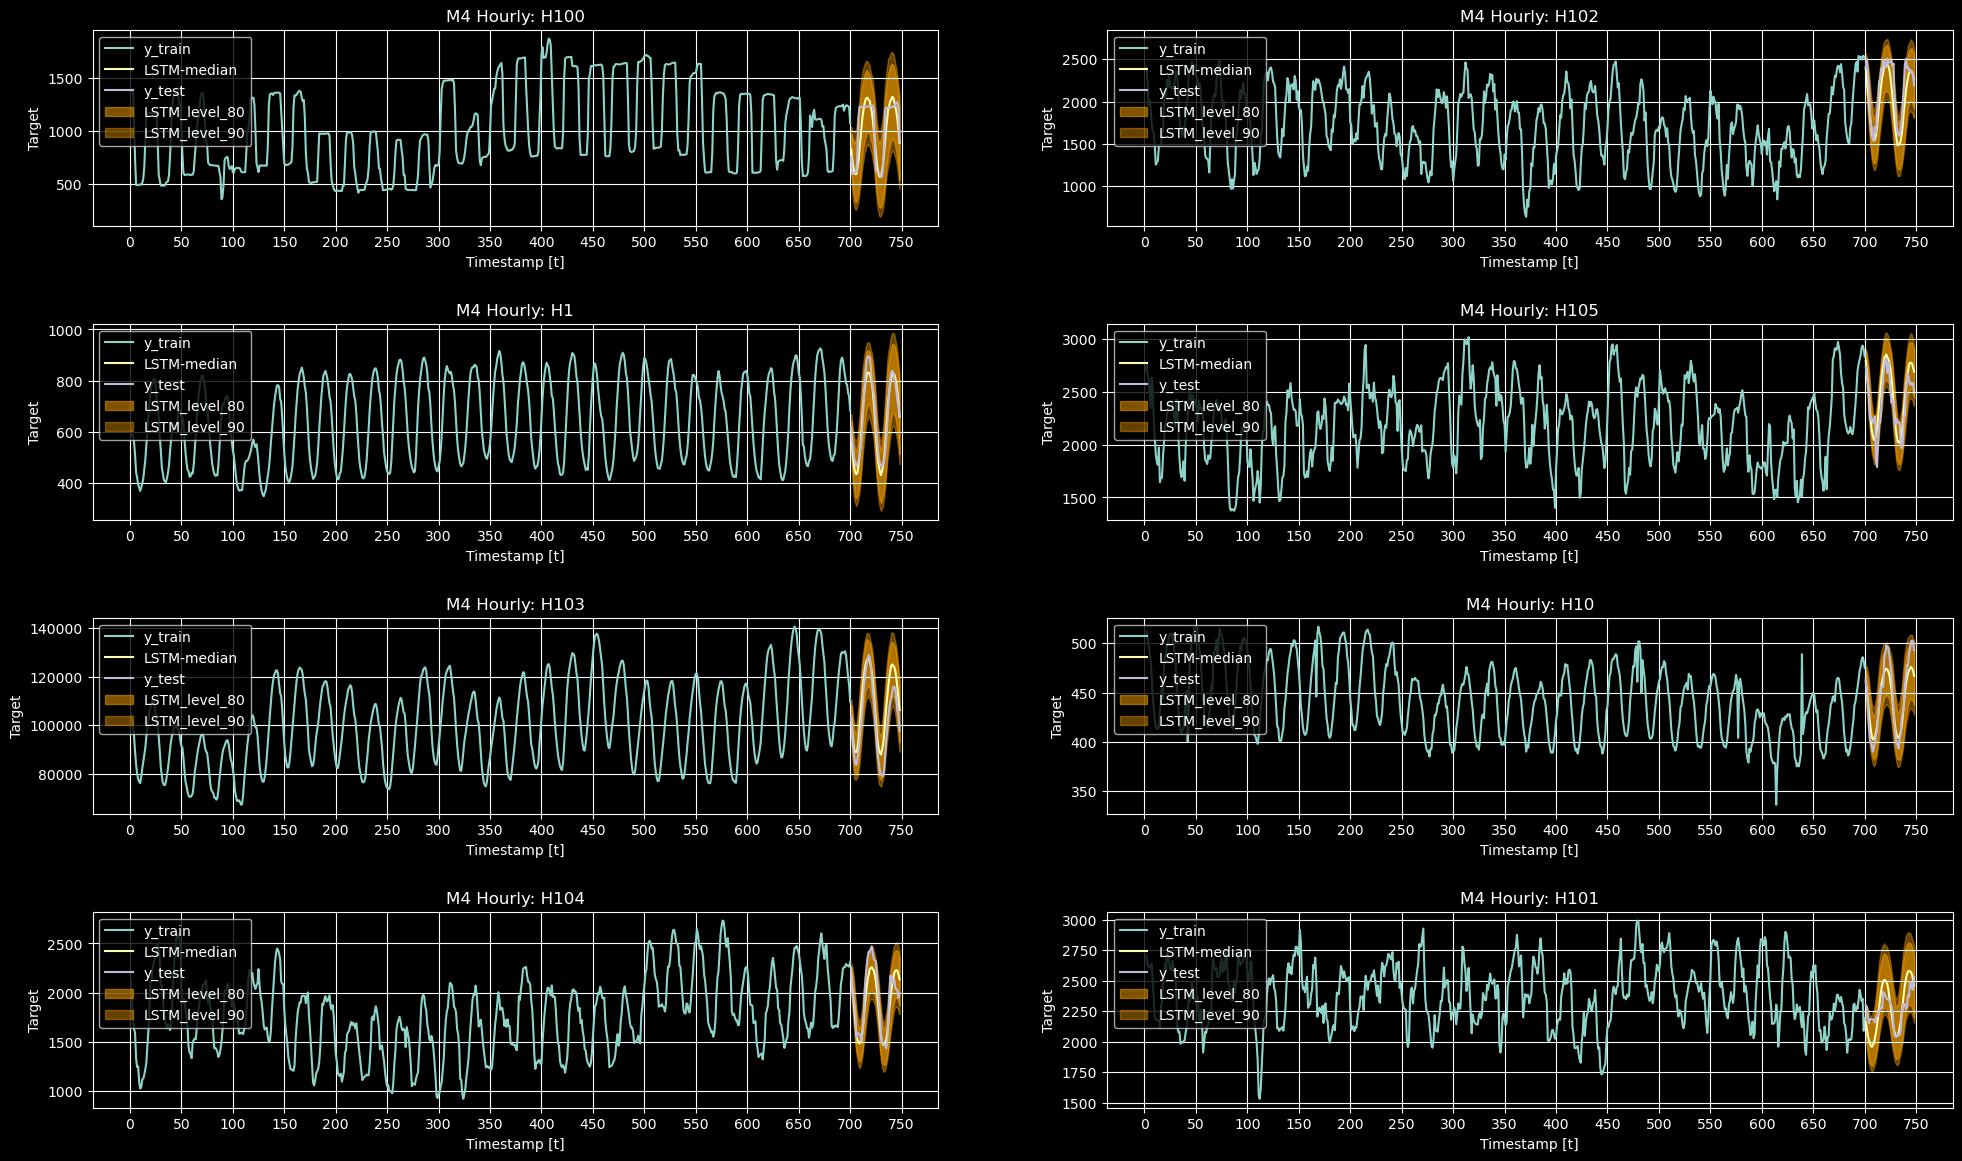

In [19]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM')